In [1]:
import pandas as pd

# Cargar el archivo CSV
data = pd.read_csv("IoT Network Intrusion Dataset Undersampled.csv")

# Mostrar las primeras filas del dataset para verificar que está cargado correctamente
print(data.head)



<bound method NDFrame.head of        Unnamed: 0  Src_Port  Dst_Port  Protocol  Flow_Duration  Tot_Fwd_Pkts  \
0              17 -1.138106  2.004022 -0.694809      -0.179158     -0.196043   
1              33 -1.138106  2.185859 -0.694809      -0.172399     -0.196043   
2              38 -1.220703 -0.851415 -0.694809       0.754273      0.567610   
3              45  0.652199 -0.360371 -0.694809      -0.177993     -0.196043   
4              47 -1.138106  2.004022 -0.694809      -0.190112     -0.386957   
...           ...       ...       ...       ...            ...           ...   
77191      625724  0.532646 -0.360371 -0.694809      -0.113200     -0.386957   
77192      625732 -1.138106  2.004022 -0.694809      -0.123222     -0.005130   
77193      625752 -1.138106  2.004022 -0.694809      -0.126718      0.185784   
77194      625776 -1.149619  0.253523 -0.694809       0.047382     -0.386957   
77195      625781 -1.138106  2.004022 -0.694809      -0.151190     -0.005130   

       To

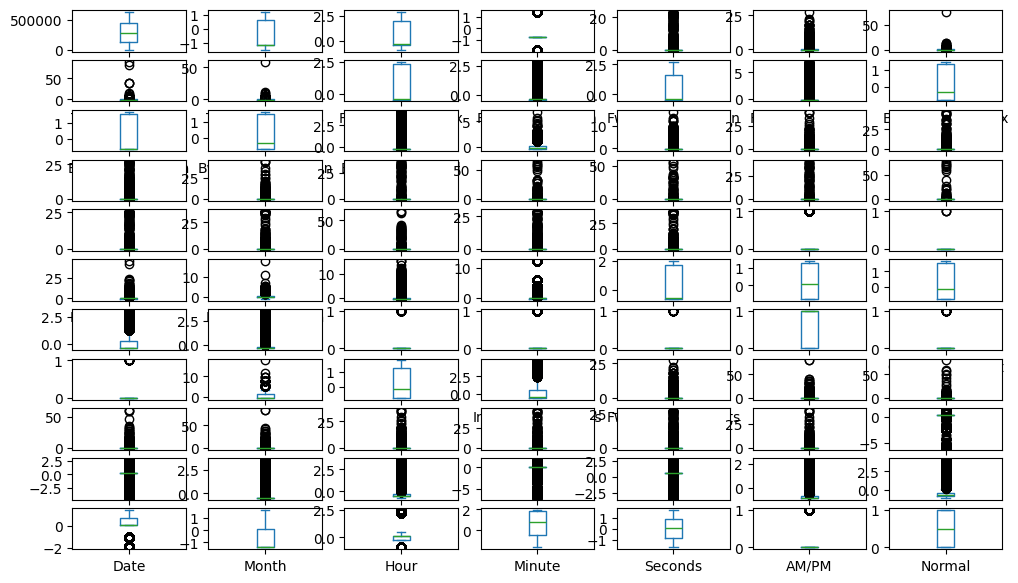

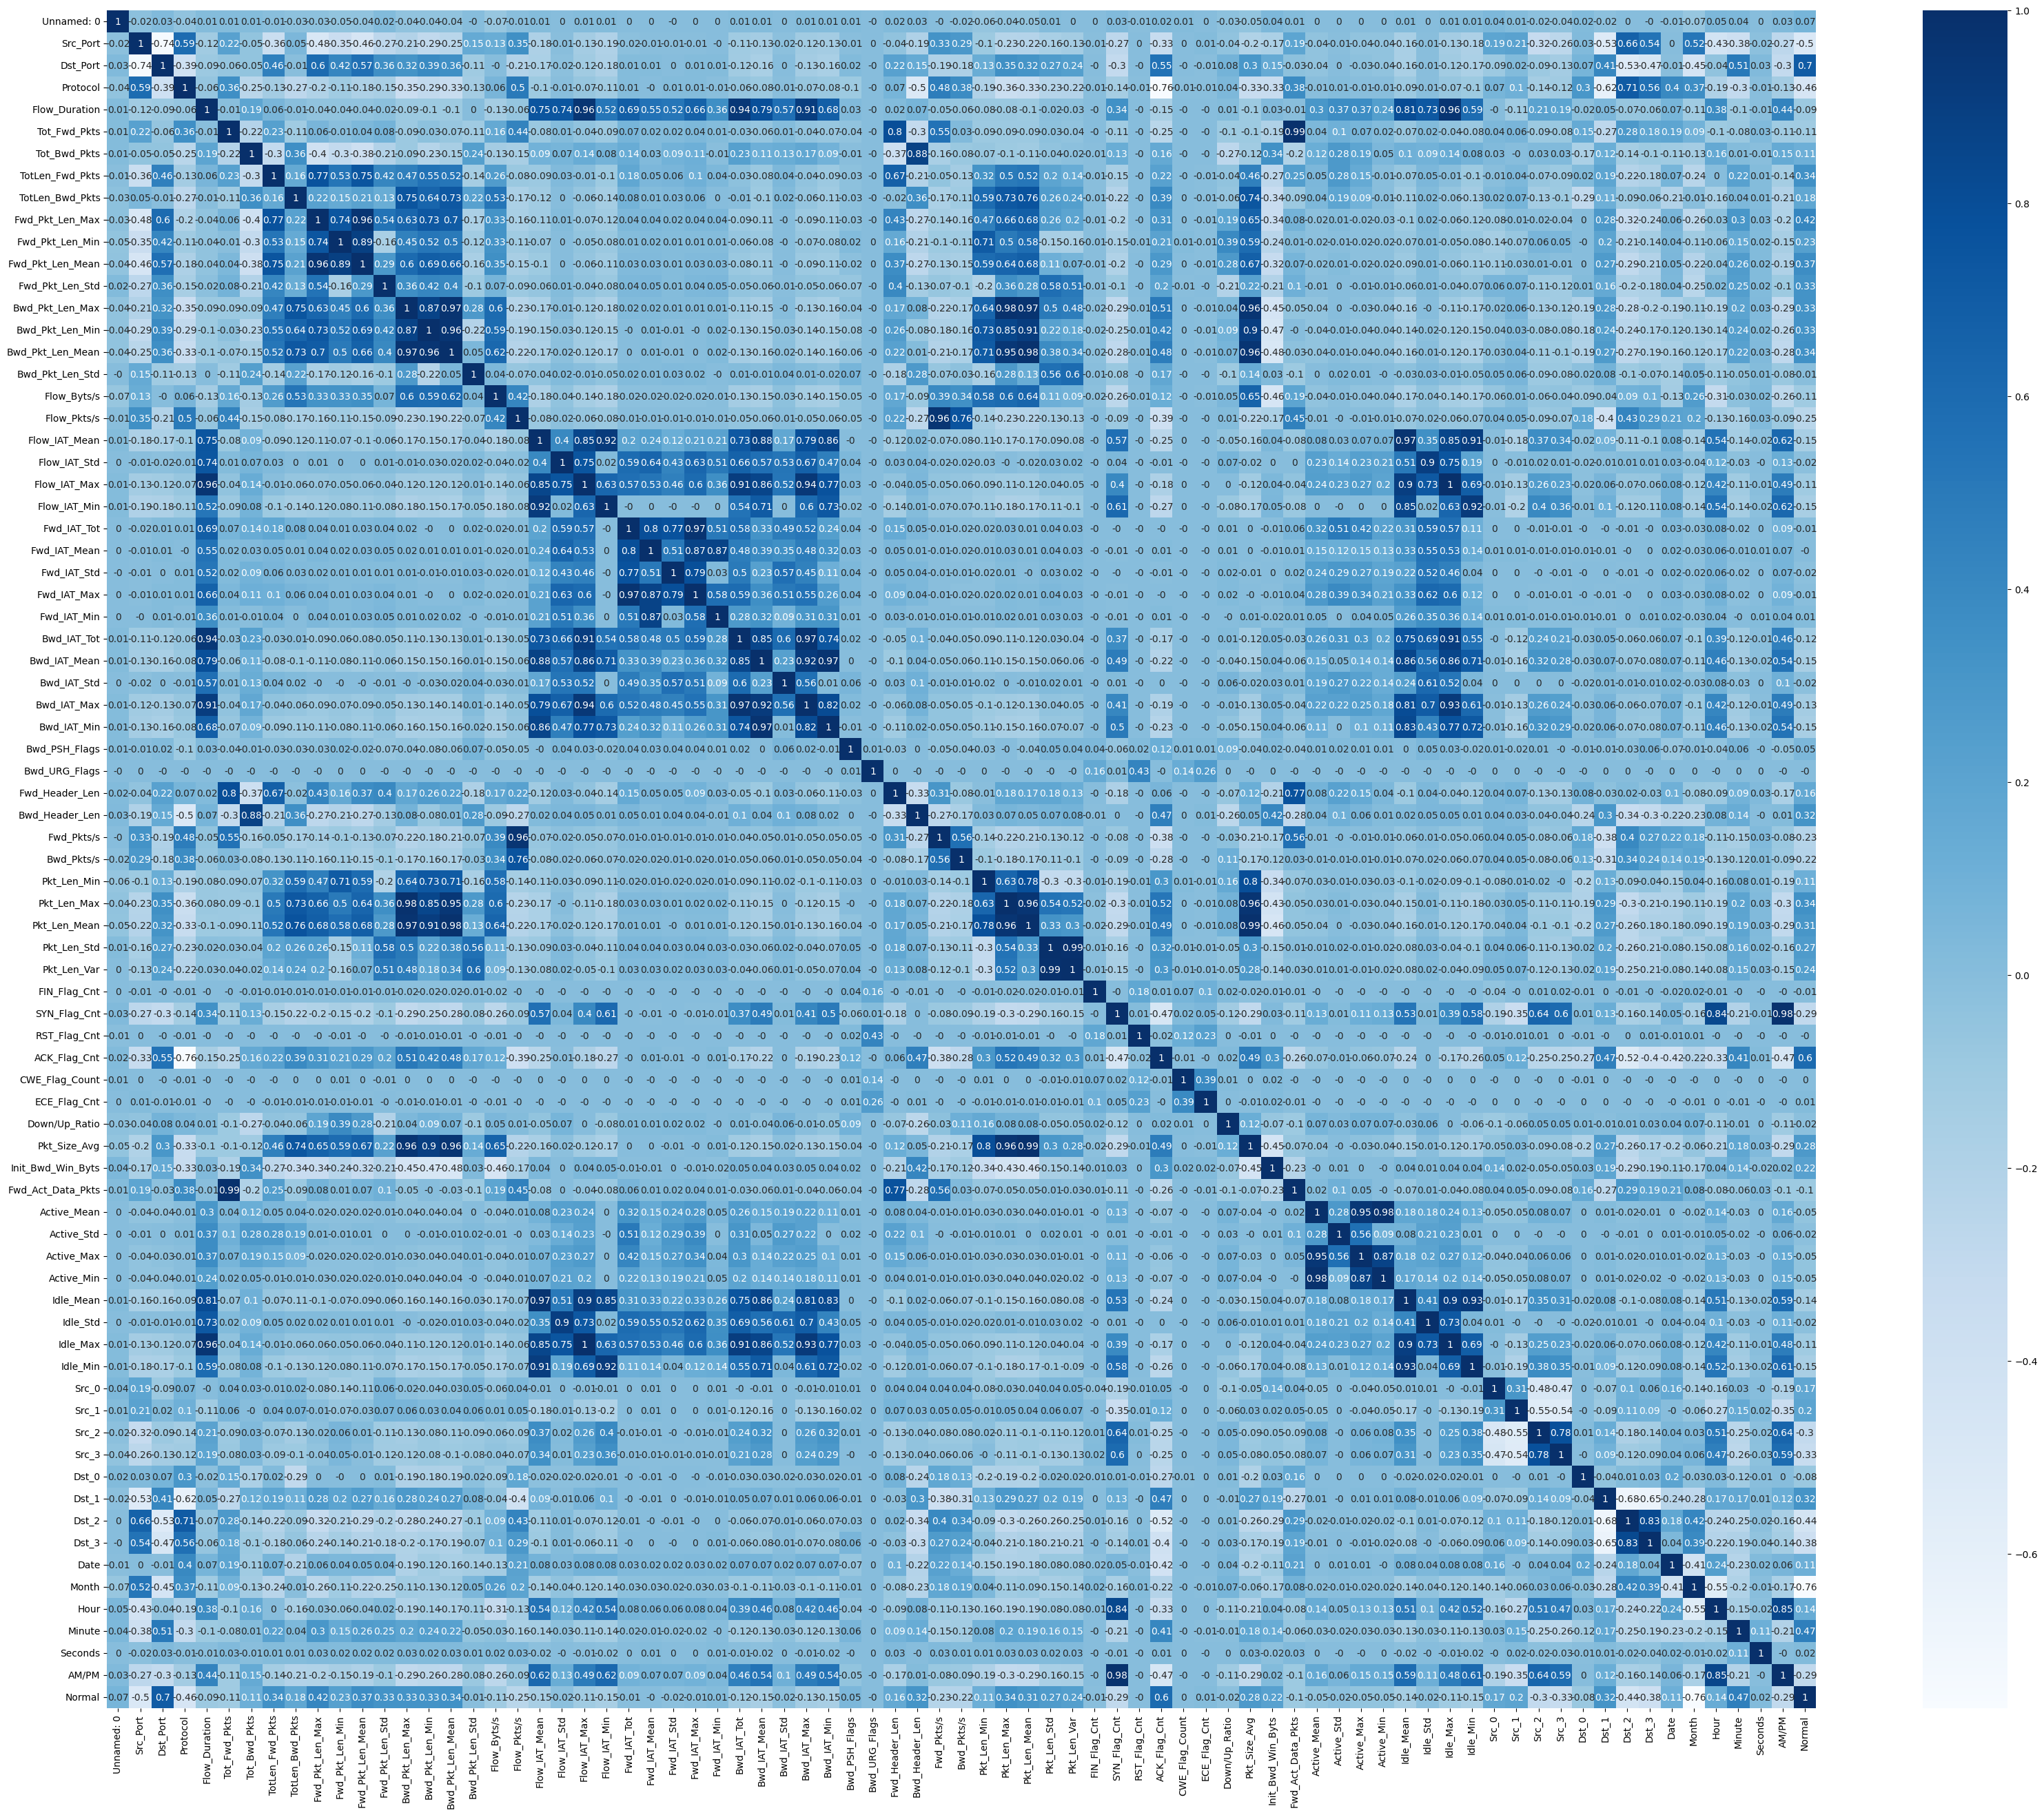

In [10]:
import matplotlib.pyplot as plt
data.plot(kind='box', subplots=True, layout=(11,7), sharex=True, sharey=False,  figsize=[12,7])
plt.show()

import seaborn as sns

df_corr = data.corr(numeric_only=True).apply(lambda x: round(x,2))
plt.figure(figsize=(40,32))
sns.heatmap(df_corr,
            annot=True,
            cmap='Blues')
plt.show()

# Calcular la matriz de correlación
correlation_matrix = data.corr()

# Identificar las columnas a eliminar
columns_to_remove = set()  # Usamos un conjunto para evitar duplicados
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:  # Verifica la correlación
            colname = correlation_matrix.columns[j]
            columns_to_remove.add(colname)

# Eliminar las columnas con alta correlación
data = data.drop(columns=columns_to_remove)


X = data.drop("Normal", axis=1).values  # Los atributos son todas las columnas excepto "label"
y = data["Normal"].values  # Las etiquetas son solo la columna "label"


In [11]:
from sklearn.preprocessing import StandardScaler
# Normalizar los atributos (X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Esto ya no se usa, los datos de este dataset estan normalizados, solo ejecutar por compatibilidad
#X_scaled=X

In [12]:
# Filtrar solo los datos normales (donde y == 1)
X_normal = X_scaled[y == 1]

# Arquitectura del Autoencoder
from keras.models import Model
from keras.layers import Input, Dense

input_dim = X_normal.shape[1]  # Número de atributos

# Definir la arquitectura del autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(40, activation='relu')(input_layer)
encoded = Dense(20, activation='relu')(encoded)

decoded = Dense(40, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el autoencoder solo con los datos normales
autoencoder.fit(X_normal, X_normal, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

Epoch 1/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4732 - val_loss: 0.3373
Epoch 2/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3964 - val_loss: 0.3341
Epoch 3/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3618 - val_loss: 0.3333
Epoch 4/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3661 - val_loss: 0.3331
Epoch 5/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3571 - val_loss: 0.3326
Epoch 6/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3677 - val_loss: 0.3324
Epoch 7/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3310 - val_loss: 0.3323
Epoch 8/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3355 - val_loss: 0.3323
Epoch 9/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3778 - val_loss: 0.3316
Epoch 10/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3546 - val_loss: 0.3314
Epoch 11/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3307 - val_loss: 0.3314
Epoch 12/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

In [13]:
import numpy as np
# Calcular el error de reconstrucción para los datos normales
X_normal_reconstructed = autoencoder.predict(X_normal)
reconstruction_error_normal = np.mean(np.square(X_normal - X_normal_reconstructed), axis=1)

# Filtrar los datos de ataque (donde y == 0)
X_attack = X_scaled[y == 0]

# Calcular el error de reconstrucción para los datos de ataque
X_attack_reconstructed = autoencoder.predict(X_attack)
reconstruction_error_attack = np.mean(np.square(X_attack - X_attack_reconstructed), axis=1)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [14]:
# Crear el conjunto de datos con los errores de reconstrucción
X_errors = np.concatenate([reconstruction_error_normal, reconstruction_error_attack], axis=0)
y_labels = np.concatenate([np.ones(len(reconstruction_error_normal)), np.zeros(len(reconstruction_error_attack))], axis=0)

# Dividir los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train_errors, X_test_errors, y_train_labels, y_test_labels = train_test_split(X_errors, y_labels, test_size=0.2, random_state=42)

In [15]:
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# Definir el modelo
def define_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=1))  # El input es el error de reconstrucción
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Salida binaria (normal o ataque)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def define_model2():
    model = Sequential()
    model.add(Dense(20, activation='relu', input_dim=1))  # El input es el error de reconstrucción
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Salida binaria (normal o ataque)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Función para realizar cross-validation
def evalua_modeloCV(model_buider, X, y, n_folds=6):
    accuracies = []  # Para almacenar las precisiones de cada fold
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=7)

    for train_ix, test_ix in kfold.split(X):
        trainX, trainY = X[train_ix], y[train_ix]
        testX, testY = X[test_ix], y[test_ix]

        # Crear el modelo para este fold
        modelo = model_buider()

        # Entrenar el modelo
        modelo.fit(trainX, trainY, epochs=30, batch_size=32, verbose=1, validation_data=(testX, testY))

        # Evaluar el modelo en el conjunto de prueba
        _, acc = modelo.evaluate(testX, testY, verbose=0)
        accuracies.append(acc)

        print(acc)

    return accuracies



In [18]:
# Suponiendo que ya tienes X_train_errors y y_train_labels listos para usar en la validación
accuracies = evalua_modeloCV(define_model, X_train_errors, y_train_labels, n_folds=6)
print(accuracies)
accuracies = evalua_modeloCV(define_model2, X_train_errors, y_train_labels, n_folds=6)
print(accuracies)


[0.8814728260040283, 0.8704944849014282, 0.8749635815620422, 0.8717575073242188, 0.8710649013519287, 0.8776719570159912]


In [92]:
#Entrenar la red neuronal sin K Fold Validation (Lo use para ver rapido el accuracy)
from keras.models import Sequential
from keras.layers import Dense

def define_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=1))  # El input es el error de reconstrucción
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Salida binaria (normal o ataque)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def define_model2():
    model = Sequential()
    model.add(Dense(20, activation='relu', input_dim=1))  # El input es el error de reconstrucción
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Salida binaria (normal o ataque)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Entrenar la red neuronal
model = define_model()
model.fit(X_train_errors, y_train_labels, epochs=5, batch_size=32, validation_data=(X_test_errors, y_test_labels))

model2=define_model2()
model2.fit(X_train_errors, y_train_labels, epochs=5, batch_size=32, validation_data=(X_test_errors, y_test_labels))

# Evaluación del modelo
accuracy = model.evaluate(X_test_errors, y_test_labels)
print(f"Accuracy: {accuracy[1]*100:.2f}%")

Epoch 1/5
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4974 - loss: 5252519.5000 - val_accuracy: 0.4998 - val_loss: 5498733.5000
Epoch 2/5
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5001 - loss: 2577376.2500 - val_accuracy: 0.5003 - val_loss: 236693.3906
Epoch 3/5
1602/1930 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4982 - loss: 1591910.2500

KeyboardInterrupt: 